In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import multivariate_normal

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda
from keras.losses import Loss, mse, MeanSquaredError
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import load_model

import tensorflow_probability as tfp

np.random.seed(1234)
tf.random.set_seed(1234)

# Bayesian Neural Network (BNN) - Theory

The objective of BNNs is to determine the posterior distribution $p(\mathbf{w}| \mathbf{D})$ that best reflects the optimal weights given the data. The key lies in understanding the concepts of the "prior" and the "posterior". The prior belief, $p(\mathbf{w})$, represents our initial hypothesis about the weights $\mathbf{w}$. As new data $\mathbf{D}$ becomes available, we update this belief to form a posterior belief, $p(\mathbf{w}| \mathbf{D})$. The theorem is formulated as:


$$ p(\mathbf{w}| \mathbf{D}) = \frac{p(\mathbf{w})p(\mathbf{D}|\mathbf{w})}{p(\mathbf{D})} $$

Each term in this equation is defined as follows:
- $ p(\mathbf{w}) $: The prior probability of the weights $\mathbf{w}$ before observing the data $D$.
- $ p(\mathbf{w}| \mathbf{D}) $: The posterior probability of the weights $\mathbf{w}$ after observing the data $\mathbf{D}$.
- $ p(\mathbf{D}|\mathbf{w}) $: The likelihood of observing the data $D$ given the weights $\mathbf{w}$.
- $ p(\mathbf{D}) $: The total probability or marginal likelihood of observing the data $D$ under all possible weights $\mathbf{w}$.

# Feedforward Step

To illustrate the feedforward step in a Bayesian Neural Network, consider a BNN with an input layer denoted by $\mathbf{X}$ with $m$ neurons, and a hidden layer represented as $\mathbf{Z}$ with $n$ neurons. The architecture ensures that every neuron in the input layer is connected to each neuron in the hidden layer through a set of weights, thereby creating a fully connected layer.

<center><img src="Images/bnn_ff.svg" width="500" height="600"></center>

For a BNN, each weight in the weight matrix $ \mathbf{w} $ and each bias in the bias vector $\mathbf{b}$ is not a fixed value. Instead, they are samples drawn from Gaussian distributions at each forward step. The weight matrix and bias vector connecting $\mathbf{X}$ and $\mathbf{Z}$ are represented as:

$$ 
\mathbf{w} =
\left( \begin{array}{cccc}
w_{11} & \cdots & w_{1n}\\
\vdots & \ddots & \vdots\\
w_{m1} & \cdots &w_{mn}
\end{array} \right),~~~~
\mathbf{b} =
\left( \begin{array}{c}
b_{1}\\
\vdots\\
b_{n}
\end{array} \right)
$$

Here, each $w_{ij}$ denotes the weight connecting the $i$-th neuron in the input layer to the $j$-th neuron in the hidden layer, and $b_j$ denotes the bias for the $j$-th neuron in the hidden layer.

Each weight $w_{ij}$ and bias $b_j$ in the BNN are associated with a mean and a variance, representing the parameters of the Gaussian distribution from which they are sampled. This introduces variability in the weights and biases, enabling BNNs to inherently model uncertainty. The reparameterization trick is employed to effectively sample the weight and bias values from their respective independent Gaussian distributions as:

$$ w_{ij} = \mu_{ij} + \sigma_{ij} \odot \epsilon_{ij} $$
$$ b_{j} = \mu_{j} + \sigma_{j} \odot \epsilon_{j} $$

In this context, $\epsilon_{ij}$ and $\epsilon_{j}$ are random samples from standard normal distributions $\mathcal{N}(0, 1)$. The terms $w_{ij}$ and $b_j$ are recognized as latent variables, allowing us to treat the weights and biases as independent variables sampled from specific distributions. In matrix format, this relationship is represented as:

$$ \mathbf{w} = \mathbf{\mu}_w + \mathbf{\sigma}_w \odot \mathbf{\epsilon}_w $$
$$ \mathbf{b} = \mathbf{\mu}_b + \mathbf{\sigma}_b \odot \mathbf{\epsilon}_b $$

The mean and variance matrices and vectors for the weights and biases are  typically initialized by sampling random values from a truncated normal distribution, denoted as $\mathcal{T}\left(0, \sqrt{\frac{2}{n+m}}\right)$. This particular distribution is employed to ensure that the initialized weights and biases are not located too far from the mean, as such extreme values could adversely affect the learning process. So, the matrix format for the mean and bias are:

$$ 
\mathbf{\mu}_w =
\left( \begin{array}{cccc}
\mu_{11} & \cdots & \mu_{1n}\\
\vdots & \ddots & \vdots\\
\mu_{m1} & \cdots &\mu_{mn}
\end{array} \right)~~~~
\mathbf{\sigma}_w =
\left( \begin{array}{cccc}
\sigma_{11} & \cdots & \sigma_{1n}\\
\vdots & \ddots & \vdots\\
\sigma_{m1} & \cdots &\sigma_{mn}
\end{array} \right).
$$

and

$$ 
\mathbf{\mu}_b =
\left( \begin{array}{c}
\mu_{1} \\
\vdots \\
\mu_{n}
\end{array} \right)~~~~
\mathbf{\sigma}_b =
\left( \begin{array}{c}
\sigma_{1}\\
\vdots\\
\sigma_{n}
\end{array} \right).
$$


While each weight and bias is modeled by an independent distribution, it’s important to note that, once sampled, they will influence each other through the network's architecture and the interactions during the feedforward and backpropagation steps. The reparameterization trick is utilized to allow gradients to pass through the sampling process, enabling the learning of the distribution's parameters.

With the weights and biases sampled, the feedforward process begins by computing the weighted sum of the inputs, adding the bias $\mathbf{b}$, and passing the result through an activation function $f(.)$. The equations governing this process are:

$$
\left\{ \begin{array}{ll} 
\mathbf{\textrm{Net}} = \mathbf{X} \mathbf{w}+ \mathbf{b}\\
\mathbf{Z} = f \left(\mathbf{\textrm{Net}}\right),
\end{array}\right.
$$


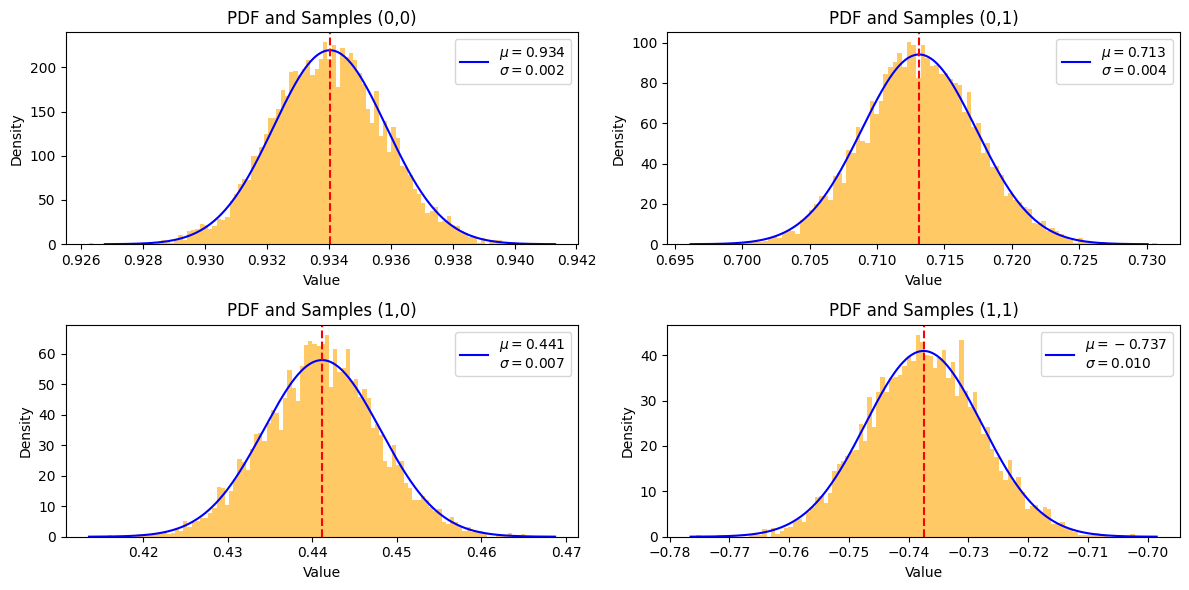

In [10]:
# Test for the Xavier initializer with truncated normal distribution
def xavier(n_in, n_out):
    return tf.random.truncated_normal(
        shape=(n_in, n_out), 
        mean=0.0,
        stddev=np.sqrt(2.0 / (n_in + n_out)))


n_in, n_out = [2, 2] 
w_mean = xavier(n_in, n_out)
w_std = xavier(n_in, n_out) - 6

fig, axes = plt.subplots(nrows=n_in, ncols=n_out, figsize=(12, 6))

# Number of samples for each histogram
num_samples = 5000

# Iterate over rows and columns
for i in range(n_in):
    for j in range(n_out):
        # Get mean and standard deviation for specific indices
        mu = w_mean[i, j]
        sigma = tf.nn.softplus(w_std[i, j])
        
        # Sample epsilon from standard normal distribution
        epsilon = tf.random.normal(shape=(num_samples,))
        
        # reparameterization trick to sample from the distribution
        samples = mu + sigma * epsilon

        # Create x values for PDF plotting
        x = np.linspace(float(mu - 4*sigma), float(mu + 4*sigma), 1000)
        
        # Compute PDF manually 
        #pdf = (1. / (sigma * np.sqrt(2. * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

        # or compute pdf using tensorflow probability distribution
        pdf = tfp.distributions.Normal(loc=mu, scale=sigma).prob(x)

        # Plot the PDF
        ax = axes[i, j]
        ax.plot(x, pdf, label=f'$\mu = {mu:.3f}$\n$\sigma = {sigma:.3f}$', color='blue')

        # Plot the histogram of samples
        ax.hist(samples.numpy(), bins=100, density=True, alpha=0.6, color='orange')

        # Draw a vertical line at the mean
        ax.axvline(mu, color='r', linestyle='--')

        ax.set_title(f'PDF and Samples ({i},{j})')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()

plt.tight_layout()
plt.show()

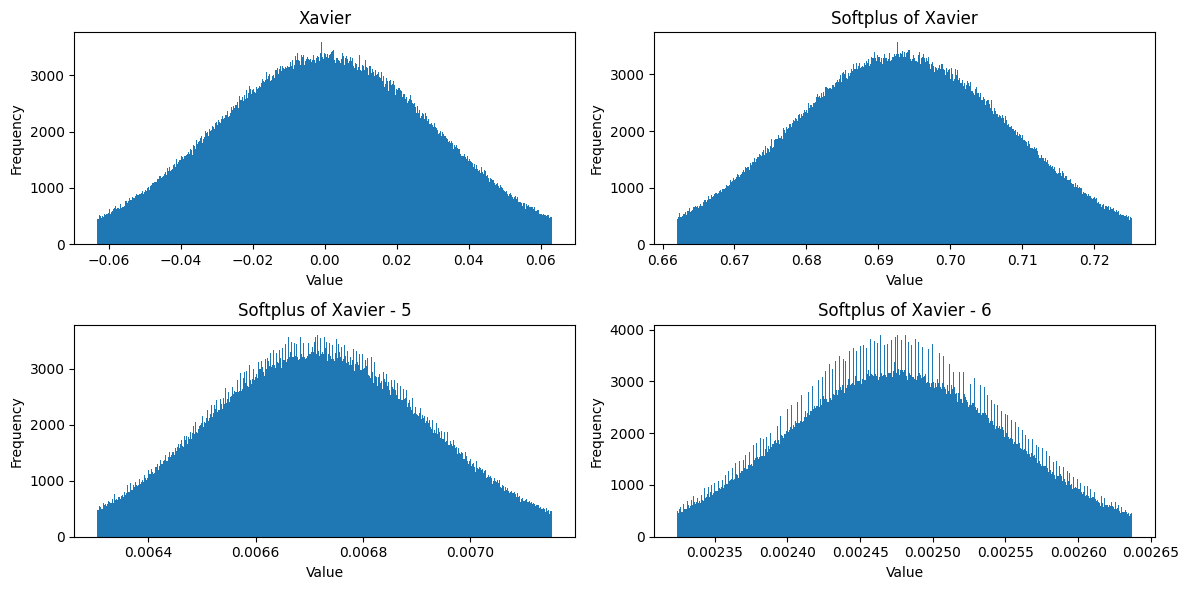

In [9]:
def plot_histograms(plot_data, titles, bins = 500, nrows = 2, ncols = 2, figsize = (12, 6)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Loop over the axes to plot each histogram
    for ax, data, title in zip(axes.flatten(), plot_data, titles):
        ax.hist(data, bins= bins, density=False)
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

softplus = lambda x: np.log(1 + np.exp(x))

n_in, n_out = [1000, 1000]  
xavier_values = xavier(n_in, n_out)
xavier_values = xavier_values.numpy()

plot_data = [
    xavier_values.flatten()[:,None],
    softplus(xavier_values.flatten()[:,None]),
    softplus(xavier_values.flatten()[:,None]-5),
    softplus(xavier_values.flatten()[:,None]-6)
]

titles = ['Xavier', 'Softplus of Xavier', 'Softplus of Xavier - 5','Softplus of Xavier - 6']


plot_histograms(plot_data, titles)

# Loss

In a BNN the goal is to compute the posterior distribution $p(\mathbf{w}| \mathbf{D})$, which represents our updated belief about the weights $\mathbf{w}$ after observing the data $\mathbf{D}$.

$$p(\mathbf{w}| \mathbf{D}) =  \frac{p(\mathbf{D}|\mathbf{w}) \cdot P(\mathbf{w})}{p(\mathbf{D})} = \frac{p(\mathbf{D}|\mathbf{w}) \cdot p(\mathbf{w})}{\int p(\mathbf{D}|\mathbf{w}')p(\mathbf{w}')d\mathbf{w}'}$$


Computing the marginal likelihood, $p(\mathbf{D})$, is particularly challenging for continuous weights as it requires integrating over the entire domain of the weights to account for all possible configurations. The integral in the denominator, $\int p(\mathbf{D}|\mathbf{w}')p(\mathbf{w}')d\mathbf{w}'$, represents the summation of probabilities over the entire continuous domain of the latent variable $\mathbf{w}$, rendering the computation of this value intractable. The same ideas would be applied also for the bias terms.

To address this issue, **variational inference** can be employed. This method approximates the true posterior distribution with a simpler, tractable distribution. The parameters of this approximating distribution are optimized to minimize the divergence between it and the true posterior. The measure used for this divergence is the **Kullback-Leibler (KL) divergence**, that will be explained in the following.


## Kullback-Leibler (KL) Divergence (Relative Entropy)

The Kullback-Leibler (KL) divergence is a measure that quantifies the difference or "distance" between two distributions. It is a powerful tool for comparing and contrasting distributions, which is particularly useful in areas such as information theory, machine learning, and statistical inference. Given two probability distributions, $p(x)$ and $q(x)$, the KL divergence can be defined using the following formula:

$$D_{KL}(p||q) =\mathbb{E}\bigg[\log{\bigg(\frac{p(x)}{q(x)}\bigg)}\bigg] $$

In the discrete case, the KL divergence is computed as:

$$D_{KL}(p||q) = \sum_x p(x)\log{\bigg(\frac{p(x)}{q(x)}\bigg)}$$

For continuous probability distributions, the KL divergence is given by the integral:

$$D_{KL}(p||q) = \int_x p(x)\log{\bigg(\frac{p(x)}{q(x)}\bigg)}$$

It is important to note that the KL divergence is not symmetric, meaning that $D_{KL}(p||q) \neq D_{KL}(q||p)$. The KL divergence can be interpreted as the expected logarithmic difference between the two probability distributions, with the expectation taken over the values of $x$ according to the distribution $p(x)$. In essence, the KL divergence quantifies the amount of information lost when we approximate the true distribution $p(x)$ using the distribution $q(x)$.

**Example 1 - Discrete**

Consider the set $w \in {0:Bad, 1:Good}$ representing the weather, and suppose that the weather being good or bad follows a Bernoulli distribution $w \sim \textbf{Bernoulli}(\theta)$. In a hypothetical scenario, two people are arguing about the chance of the weather being good. The first person says that $\theta_A = 0.8$, and the second person says that $\theta_B = 0.7$. How far apart are their opinions (distributions)?

For a Bernoulli distribution, it can be thought of as a model for the set of possible outcomes of any single experiment that asks a yes–no question. The Bernoulli distribution can be written as

$$\textbf{Bernoulli}(w,\theta) = \theta^w(1-\theta)^{1-w}$$

and the KL divergence as

$$D_{KL}(p||q) = \sum^{1}_{w=0} p(w)\log{\bigg(\frac{p(w)}{q(\mathbf{w})}\bigg)}$$

where the probabilities are $p(w) = \theta_A^w(1-\theta_A)^{1-w}$ and $q(\mathbf{w}) = \theta_B^w(1-\theta_B)^{1-w}$ . substituting in the Kl divergence:

$$D_{KL}(p||q) = \sum^{1}_{w=0} \theta_A^w(1-\theta_A)^{1-w}\log{\bigg(\frac{\theta_A^w(1-\theta_A)^{1-w}}{\theta_B^w(1-\theta_B)^{1-w}}\bigg)}$$

Now, let's evaluate the sum for $w=0$ and $w=1$:

$$D_{KL}(p||q) = (1-\theta_A)\log{\bigg(\frac{1-\theta_A}{1-\theta_B}\bigg)} + \theta_A\log{\bigg(\frac{\theta_A}{\theta_B}\bigg)}$$

Now, we can plug in the values $\theta_A = 0.8$ and $\theta_B = 0.7$ to compute the KL divergence:

$$D_{KL}(p||q) \approx 0.02573$$

This value represents the distance between the two opinions (distributions) held by the two people.

In [4]:
weather_A = tfp.distributions.Bernoulli(probs = 0.8)
weather_B = tfp.distributions.Bernoulli(probs = 0.7)

print('D(p||q)=', float(tfp.distributions.kl_divergence(weather_A, weather_B)))

D(p||q)= 0.025732100009918213


**Example 2 - Continous**

Suppose we're studying the height of adult men in two countries: Country A and Country B.
The height of adult men in Country A follows a Gaussian distribution with mean 175 cm and standard deviation 10 cm. The height of adult men in Country B follows a Gaussian distribution with mean 170 cm and standard deviation 15 cm.

we can use the Kullback-Leibler (KL) divergence to measure the difference between these two distributions. 

First, recall that the KL divergence between two Gaussian distributions $p(x)\sim \mathcal{N}(\mu_p, \sigma_p )$ and $q(x)\sim \mathcal{N}(\mu_q,\sigma_q )$ is 

$$D_{KL}(p||q) = \int_x p(x)\log{\bigg(\frac{p(x)}{q(x)}\bigg)}$$

we can substitute their probability density functions into this integral and simplify the result. A probability density function $f(x) \sim \mathcal{N}(\mu,\sigma )$ for a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$ is given by

$$f(x) = \frac{1}{\sqrt{2\pi \sigma}} \exp\bigg(-\frac{(x-\mu)^2}{2 \sigma^2}\bigg)$$

Substituting the expressions for $p(x) \sim \mathcal{N}(\mu_p,\sigma_p )$ and $q(x)\sim \mathcal{N}(\mu_q,\sigma_q )$  into the KL divergence integral and simplifying yields the formula:

$$D_{KL}(p||q) = \log\left(\frac{\sigma_q}{\sigma_p}\right) + \frac{\sigma_p^2 + (\mu_p - \mu_q)^2}{2\sigma_q^2} - \frac{1}{2}$$

Here, $p(x) \sim \mathcal{N}(175.3,7.1 )$ and $q(x)\sim \mathcal{N}(170.8,6.3)$. Substituting these values into the formula for the KL divergence gives:

$$D_{KL}(P||Q) = \log\left(\frac{6.3}{7.1}\right) + \frac{(7.1)^2 +(175.3−170.8)^2 
}{2(6.3))^2} - \frac{1}{2} \approx 0.183$$

$D_{KL}(P||Q) = 0.183$ indicate the amount of information lost when the distribution for Country B is used to approximate the distribution for Country A. This gives us a notion of how distance this two distribution are from each other.


In [5]:
mu_p, sigma_p = 175, 10
mu_q, sigma_q = 170, 15

# distributions
dist_p = tfp.distributions.Normal(loc=mu_p, scale=sigma_p)
dist_q = tfp.distributions.Normal(loc=mu_q, scale=sigma_q)

# KL divergence
kl_divergence = tfp.distributions.kl_divergence(dist_p, dist_q)
print('D(p||q)=', float(kl_divergence))

D(p||q)= 0.18324309587478638


Let's now examine a very simple example to help us understand the mechanics and foundational concept behind minimizing KL divergence to align two distributions.

**Naive Example 3 - Variational Inference idea**

Imagine we do not know the true distribution of adult men's heights in Country B, yet we seek to estimate it. We are tasked with adjusting the parameters of a variational distribution, denoted as $\mu_b$ and $\sigma_b$, which expresses our belief about Country B. Our goal is to construct an approximating distribution so that it resembles the established distribution of Country A. In Country A, the heights of adult men adhere to a Gaussian distribution, characterized by a mean $\mu_a = 175$ cm and a standard deviation $\sigma_a = 10$ cm.

By minimizing the KL divergence between the variational distribution and the true distribution of Country A, we aim to make the two distributions more similar and reduce the information loss.

In [14]:
# Given parameters for distribution of Country A
mu_a = 175  
sigma_a = 10  

# Initialize parameters for distribution of Country B 
mu_b = tf.Variable(170.0)  # initial mean of Country B
sigma_b = tf.Variable(15.0)  # initial standard deviation of Country B

# Define the distributions
dist_a = tfp.distributions.Normal(loc=mu_a, scale=sigma_a)
dist_b = lambda: tfp.distributions.Normal(loc=mu_b, scale=tf.abs(sigma_b))  # ensure scale is positive

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Optimization loop to minimize KL divergence
for step in range(1000):
    with tf.GradientTape() as tape:
        kl_divergence = tfp.distributions.kl_divergence(dist_a, dist_b())
    gradients = tape.gradient(kl_divergence, [mu_b, sigma_b])
    optimizer.apply_gradients(zip(gradients, [mu_b, sigma_b]))
    if step % 100 == 0:
        print(f'Step {step}, KL Divergence: {kl_divergence.numpy()}, mu_b: {mu_b.numpy()}, sigma_b: {sigma_b.numpy()}')

print('Optimized parameters for Country B distribution:')
print('mu_b:', mu_b.numpy())
print('sigma_b:', sigma_b.numpy())

Step 0, KL Divergence: 0.18324309587478638, mu_b: 170.00999450683594, sigma_b: 14.99000072479248
Step 100, KL Divergence: 0.1327359676361084, mu_b: 170.99615478515625, sigma_b: 13.992469787597656
Step 200, KL Divergence: 0.08696654438972473, mu_b: 171.9324188232422, sigma_b: 13.017695426940918
Step 300, KL Divergence: 0.04924333095550537, mu_b: 172.7904815673828, sigma_b: 12.105071067810059
Step 400, KL Divergence: 0.022624388337135315, mu_b: 173.5334014892578, sigma_b: 11.311627388000488
Step 500, KL Divergence: 0.007868528366088867, mu_b: 174.1212615966797, sigma_b: 10.702085494995117
Step 600, KL Divergence: 0.0019927453249692917, mu_b: 174.53131103515625, sigma_b: 10.312849998474121
Step 700, KL Divergence: 0.0003786953166127205, mu_b: 174.7775421142578, sigma_b: 10.115201950073242
Step 800, KL Divergence: 5.826866254210472e-05, mu_b: 174.9052276611328, sigma_b: 10.035528182983398
Step 900, KL Divergence: 7.673865184187889e-06, mu_b: 174.9635009765625, sigma_b: 10.009315490722656
O

In this scenario, we are applying the foundational idea that leads to variational inference. We employ an approximating distribution and minimize the KL divergence to closely resemble a target distribution we desire to model. This concept takes a central role in Variational Inference, particularly useful when faced with intractable true distributions, especially in Bayesian modeling where the objective is to estimate a posterior distribution relying on observed data and prior beliefs.

From what we observe, the Kullback-Leibler (KL) divergence acts as a fundamental connector in the approximation process within variational inference. It quantifies the difference or "distance" between two distributions, offering a method to assess the accuracy with which the approximating distribution mirrors the true posterior in a Bayesian model. The concept of variational inference and the role of KL divergence will be explored in more detail in the following section.

## Variational Inference and Evidence Lower Bound (ELBO)

Variational inference is a powerful technique used in Bayesian modeling to approximate complex posterior distributions. The main challenge in Bayesian inference is computing the posterior distribution $p(\mathbf{w}| \mathbf{D})$, which involves the intractable integral of the marginal likelihood $p(\mathbf{D})$. Variational inference addresses this challenge by introducing a simpler, parametrized distribution $q(\mathbf{w})$ to approximate the true posterior distribution.

In the context of neural networks, during the feedforward step, we deal with weights and biases that need to be learned. In a Bayesian neural network, rather than having fixed values, the weights and biases are treated as random variables. These variables are sampled from independent Gaussian distributions. The Gaussian distributions are characterized by mean and variance, which are represented as learnable parameters: $\mu_w$, $\sigma_w$ for weights, and $\mu_b$, $\sigma_b$ for biases.

After sampling the weights and biases and performing the feedforward calculations to obtain the output from the layer, we use the learned parameters of mean and variance to define variational distributions for both weights and biases, denoted as $q(\mathbf{w})$ and $q(\mathbf{b})$, respectively.

These variational distributions are formulated as multidimensional Gaussian distributions:

For the weights:
$$q(\mathbf{w}) = \frac{1}{(2\pi)^{\frac{mn}{2}}|\boldsymbol{\Sigma}_w|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{w} - \boldsymbol{\mu}_w)^T \boldsymbol{\Sigma}_w^{-1} (\mathbf{w} - \boldsymbol{\mu}_w)\right),$$


For the biases:
$$q(\mathbf{b}) = \frac{1}{(2\pi)^{n/2}|\boldsymbol{\Sigma}_b|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{b} - \boldsymbol{\mu}_b)^T \boldsymbol{\Sigma}_b^{-1} (\mathbf{b} - \boldsymbol{\mu}_b)\right),$$

Here, $\boldsymbol{\Sigma}_w$ and $\boldsymbol{\Sigma}_b$ are diagonal covariance matrices for weights and biases respectively. These matrices are diagonal, meaning that only the elements on the main diagonal are non-zero. These non-zero elements are the variances of the weights and biases, represented by $\sigma_w$ and $\sigma_b$ respectively. We can calculate the covariance matrices $ \mathbf{\Sigma}_w $ and $ \mathbf{\Sigma}_b $ by squaring each element of $ \mathbf{\sigma}_w $ and $ \mathbf{\sigma}_b $ respectively:

$$
\mathbf{\Sigma_w} =
\left( \begin{array}{cccc}
\sigma_{11}^2 & 0 & \cdots & 0\\
0 & \sigma_{12}^2 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & \sigma_{mn}^2
\end{array} \right),~~~~~~
\mathbf{\Sigma_b} =
\left( \begin{array}{cccc}
\sigma_{1}^2 & 0 & \cdots & 0\\
0 & \sigma_{2}^2 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & \sigma_{n}^2
\end{array} \right).
$$

Where $m$ is the number of rows in the weight matrix, representing the number of input features or connections from the previous layer and $n$ is the number of columns in the weight matrix, representing the number of neurons in the current layer, and also the dimensionality of the bias vector.


In this setup, the task is to optimize the parameters of the variational distributions ($\mu_w$, $\sigma_w$, $\mu_b$, $\sigma_b$) such that $q(\mathbf{w})$ and $q(\mathbf{b})$ closely approximate the true posterior distributions of weights and biases given the data, i.e., $p(\mathbf{w}| \mathbf{D})$ and $p(\mathbf{b}| \mathbf{D})$. We aim to demonstrate that the KL-divergence can be decomposed into a term known as the ELBO and another constant term. These can be minimized to bring the variational distribution closer to the true posterior, remarkably, even without explicit knowledge of the true posterior itself. By doing so, we can make Bayesian inferences about the weights and biases of the neural network, incorporating uncertainty in our model.

To address this, we utilize the continuous KL-divergence to find a distribution $q(\mathbf{w})$ that closely approximates the true posterior distribution $p(\mathbf{w}| \mathbf{D})$. The goal is to minimize the KL-divergence to ensure the most accurate approximation possible.

$$D_{KL}(q(\mathbf{w})||p(\mathbf{w}|\mathbf{D})) = \int q(\mathbf{w'})\log{\bigg(\frac{q(\mathbf{w'})}{p(\mathbf{w'}| \mathbf{D})}\bigg)}d\mathbf{w'}$$

It may seem unusual that we choose $q(\mathbf{w'})$ instead of $p(\mathbf{w'}| \mathbf{D})$ in the integrand, but this is due to the lack of direct access to the true posterior distribution.  Thus we are using $q(\mathbf{w'})$ to approximate the intractable true posterior $p(\mathbf{w'}| \mathbf{D})$, so it’s natural to use $q(\mathbf{w})$ in the computations.

Substituting Bayes' formula,

$$p(\mathbf{w'}| \mathbf{D}) = \frac{p(\mathbf{D}|\mathbf{w'})p(\mathbf{w'})}{p(\mathbf{D})}, $$ 

into the KL divergence gives:

$$D_{KL}(q(\mathbf{w})||p(\mathbf{w}|\mathbf{D})) = \int q(\mathbf{w'})\log{\bigg(\frac{q(\mathbf{w'})p(\mathbf{D})}{p(\mathbf{D}|\mathbf{w'})p(\mathbf{w'})}\bigg)}d\mathbf{w'}$$

We have information about the joint probability distribution $p(\mathbf{D}|\mathbf{w'})p(\mathbf{w'})$, but not about the marginal distribution $p(\mathbf{D})$. Rearranging the integral in terms of known and unknown probabilities gives and simplifying the notation of the KL-divergence:

$$D_{KL}(q||p) = \int q(\mathbf{w'})\log{\bigg(\frac{q(\mathbf{w'})}{p(\mathbf{D}|\mathbf{w'})p(\mathbf{w'})}\bigg)}d\mathbf{w'} + \log{p(\mathbf{D})}$$

Now, we aim to express this KL-divergence as a sum of expectations. Given a continuous probability distribution $q(\mathbf{w})$ for a random variable $\mathbf{w}$, and a function of this variable denoted as $g(\mathbf{w})$, the expectation value of $g$ with respect to the distribution $q(\mathbf{w})$ is calculated by:

$$\mathbb{E}_{\mathbf{w} \sim q}[g(\mathbf{w})] = \int g(\mathbf{w})q(\mathbf{w})d\mathbf{w}$$

With this, we can reinterpret the terms in the KL-divergence as expectation values, where the probabilities under the distribution $q(\mathbf{w})$ serve as the weights:

$$D_{KL}(q||p) = \mathbb{E}_{\mathbf{w} \sim q}\bigg[\log{\frac{q(\mathbf{w})}{p(\mathbf{D}|\mathbf{w})p(\mathbf{w})}}\bigg] + \log{p(\mathbf{D})}$$

Since $p(\mathbf{D})$ is not dependent on $\mathbf{w}$, the expectation $\mathbb{E}_{\mathbf{w} \sim q}[\log{p(\mathbf{D})}]$ simplifies to $\log{p(\mathbf{D})}$. Reversing the fraction in the first expectation and introducing a minus sign in the logarithm yields:

$$D_{KL}(q||p) = -\mathbb{E}_{\mathbf{w} \sim q}\bigg[\log{\frac{p(\mathbf{D}|\mathbf{w})p(\mathbf{w})}{q(\mathbf{w})}}\bigg] + \log{p(\mathbf{D})}$$

Let's denote the first expectation as the Evidence Lower Bound as $\text{ELBO}(q(\mathbf{w})) = \mathbb{E}_{\mathbf{w} \sim q}\bigg[\log{\frac{p(\mathbf{D}|\mathbf{w})p(\mathbf{w})}{q(\mathbf{w})}}\bigg]$, and finally we can express the KL-divergence as:

$$D_{KL}(q(\mathbf{w})||p(\mathbf{w}|\mathbf{D})) = -\text{ELBO}(q(\mathbf{w})) + \log{p(\mathbf{D})}$$


We know that the KL-divergence must be non-negative , $D_{KL}(q||p) \geq 0 $, as it measures the information loss between the true posterior distribution $p(\mathbf{w}| \mathbf{D})$ and the variational distribution $ q(\mathbf{w}) $. The term $ \log{p(\mathbf{D})} $ is constant for a given input data. Given the properties of logarithms and since $0 < p(\mathbf{D}) \leq 1$, the log term must be $\log{p(\mathbf{D})} \leq 0$ .

Now, consider the Evidence Lower Bound (ELBO) represented as $\text{ELBO}(q(\mathbf{w}))$. As per its definition, the relationship between ELBO, the log marginal likelihood, and the KL-divergence is such that:

$$- \text{ELBO}(q(\mathbf{w})) + \log{p(\mathbf{D})}\geq 0$$

Re-arranging terms, we observe:

$$0 \geq  \log{p(\mathbf{D})}\geq \text{ELBO}(q(\mathbf{w})) $$

This inequality is a clear indication that the ELBO serves as a lower bound to the log marginal likelihood, $\log{p(\mathbf{D})}$, hence the name Evidence Lower Bound.

Note that maximizing the ELBO is equivalent to minimizing the KL-divergence between the variational distribution $q(\mathbf{w})$ and the true posterior $p(\mathbf{w}|\mathbf{D})$. The idea behind this is that by minimizing the information loss represented by the KL-divergence, we are essentially approximate the true posterior by the variational distribution.

Thus, ELBO term encapsulates the difference between the log marginal likelihood and the KL-divergence. Consequently, when the KL-divergence approaches zero, which indicates that the variational distribution is converging to the true posterior, the ELBO is approaching the log marginal likelihood, underlining the importance of maximizing the ELBO in variational inference.



# Backpropagation Step